In [1]:
%matplotlib inline
#%matplotlib qt
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pylab as plt
import root_numpy
import pandas as pd
import numpy as np
import numpy
from scipy.stats import gaussian_kde
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import maxflow

BRICK_X = 124000
# Changed due to ignorance of 57th layer. Originally : #BRICK_Y = 99000
BRICK_Y = 76710
BRICK_Z = 75000
SAFE_M = 10000
dZ = 205

import numpy.linalg as la
 
def angle(v1, v2):
    cos = (v1*v2).sum(axis=1)
    sin = la.norm(numpy.cross(v1, v2, axis=1), axis=1)
    return numpy.arctan2(sin, cos)

/home/acapello/anaconda3/lib/python3.5/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.11.3 is currently installed but you installed root_numpy against numpy 1.11.2. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


Все основные функции для чтения/записи:

In [2]:
def load_bg(step=1000):
    # ignore 57th layer since it looks different
    etalon_plates = []
    for p in range(48, 57):
        backtracks = root_numpy.root2array("data-2016/129294.{p}.1.1000.cp.root".format(p=p), 
                                       treename="couples", 
                                       branches=["s.eX", "s.eY", "s.eZ",
                                                "s.eTX", "s.eTY",
                                                "s.eChi2"], step=step)
        etalon_plates.append(backtracks)
        
    df = None
    for p in range(58):
        plate = numpy.copy(etalon_plates[p % len(etalon_plates)])
        plate['s.eZ'] = p * 1293
        # plt.hist(backtracks['s.eY'], bins=100, histtype='step', label="%d"%p)
        if df is None:
            df = pd.DataFrame(plate)
            # print ">", df.shape
        else:
            df = pd.concat([df, pd.DataFrame(plate)], ignore_index=True)
    # plt.legend()
    print ("bg: {n} tracks".format(n=df.shape[0]))
    return df

def load_mc(filename="data-2016/mcdata_taue2.root", step=1):
    mc = root_numpy.root2array(
                        filename,
                        treename="Data",
                        branches=["Event_id", "ele_P",
                                   "BT_X", "BT_Y", "BT_Z",
                                   "BT_SX", "BT_SY",
                                   "ele_x", "ele_y", "ele_z", 
                                   "ele_sx", "ele_sy", 
                                   "chisquare"],
                        step=step)
    pmc = pd.DataFrame(mc)
    pmc['numtracks'] = pmc.BT_X.apply(lambda x: len(x))
    # cuts
    shapechange = [pmc.shape[0]]
    pmc = pmc[pmc.ele_P > 0.1]
    shapechange.append(pmc.shape[0])
    
    #pmc = pmc[pmc.ele_x.abs() < BRICK_X / 2 - SAFE_M]
    #shapechange.append(pmc.shape[0])
    ele_x = numpy.random.uniform(BRICK_X / 2 - SAFE_M, BRICK_X / 2 + SAFE_M, size=pmc.shape[0])
    delta_ele_x = pmc.ele_x - ele_x
    pmc.ele_x = ele_x
    pmc.BT_X -= delta_ele_x
    
    #pmc = pmc[pmc.ele_y.abs() < BRICK_Y / 2 - SAFE_M]
    #shapechange.append(pmc.shape[0])
    ele_y = numpy.random.uniform(BRICK_Y / 2 - SAFE_M, BRICK_Y / 2 + SAFE_M, size=pmc.shape[0])
    delta_ele_y = pmc.ele_y - ele_y
    pmc.ele_y = ele_y
    pmc.BT_Y -= delta_ele_y
    
    pmc = pmc[pmc.ele_z < 0]
    shapechange.append(pmc.shape[0])
    
    pmc = pmc[pmc.numtracks > 3]
    shapechange.append(pmc.shape[0])
    print ("numtracks reduction by cuts: ", shapechange)
    # calc centers
    # to brick reference frame and center
    pmc['m_BT_X'] = pmc.BT_X.apply(lambda x: x.mean())
    pmc['m_BT_Y'] = pmc.BT_Y.apply(lambda x: x.mean())
    pmc['m_BT_Z'] = pmc.BT_Z.apply(lambda x: x.mean())
    #pmc.BT_X += BRICK_X / 2
    #pmc.BT_Y += BRICK_Y / 2
    pmc.BT_Z += BRICK_Z / 2
    #pmc.ele_x += BRICK_X / 2
    #pmc.ele_y += BRICK_Y / 2
    pmc.ele_z += BRICK_Z / 2
    print ("len(pmc): {len}".format(len=len(pmc)))
    return pmc

In [3]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

def metric_res(u, v):
    X = numpy.array([[u[0], u[0] + u[3]*dZ, v[0], v[0] + v[3]*dZ], 
                     [u[1], u[1] + u[4]*dZ, v[1], v[1] + v[4]*dZ],
                     [u[2], u[2] + dZ, v[2], v[2] + dZ]]).T
    pca = PCA(n_components=1).fit(X)
    t = ((X - pca.mean_)/pca.components_).mean(axis=1)
    res = (X - pca.mean_) - pca.components_*t[:,numpy.newaxis]
    residual = numpy.sqrt(((res**2).sum(axis=1)).sum())
    return residual

def metric_angle(u, v):
    alpha_1 = angle(numpy.array([[u[3], u[4], 1]]), 
                    numpy.array([[v[0] - u[0], v[1] - u[1], v[2] - u[2]]]))
    alpha_2 = angle(numpy.array([[u[3], u[4], 1]]), 
                    numpy.array([[v[0] + dZ*v[3] - u[0], v[1] + dZ*v[4] - u[1], v[2] + dZ - u[2]]]))
    alpha_3 = angle(numpy.array([[v[3], v[4], 1]]), 
                    numpy.array([[v[0] + dZ*v[3] - u[0], v[1] + dZ*v[4] - u[1], v[2] + dZ - u[2]]]))
    alpha_4 = angle(numpy.array([[v[3], v[4], 1]]), 
                    numpy.array([[v[0] + dZ*v[3] - u[0] - dZ*u[3], v[1] + dZ*v[4] - u[1] - dZ*u[4], v[2]  - u[2]]]))
    alpha_1 = min(alpha_1, numpy.pi - alpha_1)
    alpha_2 = min(alpha_2, numpy.pi - alpha_2)
    alpha_3 = min(alpha_3, numpy.pi - alpha_3)
    alpha_4 = min(alpha_4, numpy.pi - alpha_4)
    return alpha_1 + alpha_2 + alpha_3 + alpha_4

In [4]:
def plot_bg(df, step=1):
    dZ = 205
    # mind the order!
    d0 = pd.DataFrame([
                df['s.eZ'][::step],
                df['s.eX'][::step],
                df['s.eY'][::step]],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['s.eTX'][::step]*dZ,
            df['s.eTY'][::step]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    C = plt.cm.Blues(0.5)
    lc = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.5, lw=2)

    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-84, elev=10)
    ax.add_collection3d(lc)
    
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(d0['z'].min(), d0['z'].max())
    ax.set_ylim(d0['x'].min(), d0['x'].max())
    ax.set_zlim(d0['y'].min(), d0['y'].max())
    print ("len(slopes): {slopes}".format(slopes=numtracks))

In [5]:
#Функция для 
def round_Z_coodr(x):
    return BT_Z_unique[np.argmin(np.abs(BT_Z_unique - x))]
round_Z_coodr = np.vectorize(round_Z_coodr)

In [6]:
import copy
def combine_mc_bg(pmc, pbg, id=0):
    dZ = 204
    #random permutation of basetracks in background
    #pbg['s.eX'] = pbg['s.eX'].sample(frac=1)
    #pbg['s.eY'] = pbg['s.eY'].sample(frac=1)
    #pbg['s.eZ'] = pbg['s.eZ'].sample(frac=1)
    df = copy.deepcopy(pmc.iloc[id])
    delta = BT_Z_unique[-1] - df['BT_Z'].max()
    df['BT_Z'] += delta
    df['ele_z'] += delta
    df['BT_Z'] = round_Z_coodr(df['BT_Z'])
    df['ele_z'] = round_Z_coodr(df['ele_z']).ravel()[0]
    frac_z = (BT_Z_unique.max() - df.ele_z)/(BT_Z_unique.max() - BT_Z_unique.min())
    pbg = pbg.sample(frac=frac_z)
    pbg['s.eZ'] = numpy.random.choice(BT_Z_unique[BT_Z_unique >= df.ele_z], size=len(pbg))
    dmix = pd.DataFrame([
                pbg['s.eX'],
                pbg['s.eY'],
                pbg['s.eZ'],
                pbg['s.eTX'],
                pbg['s.eTY'],
                pbg['s.eX'] + pbg['s.eTX']*dZ,
                pbg['s.eY'] + pbg['s.eTY']*dZ,
                pbg['s.eZ'] + dZ,
                pbg['s.eChi2']],
                index=['sx', 'sy', 'sz', 'TX', 'TY', 
                       'ex', 'ey', 'ez', 'chi2']).T
    dmix['signal'] = 0
       
    dmc = pd.DataFrame([        
                df['BT_X'],
                df['BT_Y'],
                df['BT_Z'],
                df['BT_SX'],
                df['BT_SY'],
                df['BT_X'] + df['BT_SX']*dZ,
                df['BT_Y'] + df['BT_SY']*dZ,
                df['BT_Z'] + dZ,
                df['chisquare'][:len(df['BT_X'])]],
                index=['sx', 'sy', 'sz', 'TX', 'TY', 
              'ex', 'ey', 'ez', 'chi2']).T
    dmc['signal'] = 1
    
    dd = pd.concat([dmix, dmc])
    dd['ele_x'] = df['ele_x']
    dd['ele_y'] = df['ele_y']
    dd['ele_z'] = df['ele_z']
    dd['ele_sx'] = df['ele_sx']
    dd['ele_sy'] = df['ele_sy']
    dd['ele_sz'] = 1
    alpha = angle(numpy.array([(dd['sx'] - dd['ele_x']), (dd['sy'] - dd['ele_y']), (dd['sz'] - dd['ele_z'])]).T, 
                  numpy.array([dd['ele_sx'], dd['ele_sy'], dd['ele_sz']]).T)
    dd['alpha'] = alpha
    dd = dd.loc[dd.chi2 < 3]
    dd = dd.loc[dd.sz > 62063]
    return dd

In [7]:
def cartesian_to_spherical(x,y,z):
    r_xy = x**2 + y**2
    r = numpy.sqrt(r_xy + z**2)
    theta = numpy.arctan2(z, numpy.sqrt(r_xy))
    phi = numpy.arctan2(y, x)
    return numpy.array([numpy.cos(phi)*numpy.cos(theta), numpy.sin(phi)*numpy.cos(theta), numpy.sin(theta)])

def Simple_Hough3D(sx, sy, sz, ex, ey):
    B = cartesian_to_spherical(ex - sx, ey - sy, 205)
    X = (1 - B[0]**2/(1 + B[2])) * sx - B[0] * B[1] / (1 + B[2]) * sy - B[0] * sz
    Y = - B[0] * B[1] / (1 + B[2]) * sx + (1 - B[1]**2/(1 + B[2])) * sy - B[1] * sz
    return B, X.reshape((1,-1)), Y.reshape((1,-1))

#example
#Hough = numpy.concatenate(Simple_Hough3D(train_np[:, 1], train_np[:, 2], train_np[:, 3],
#                       train_np[:, 6], train_np[:, 7])).T

In [8]:
pbg = load_bg(step=10)
BT_Z_unique = numpy.unique(pbg['s.eZ'])
bg_density = len(pbg)/((pbg['s.eZ'].max() - pbg['s.eZ'].min())*
                       (pbg['s.eY'].max() - pbg['s.eY'].min())*
                       (pbg['s.eX'].max() - pbg['s.eX'].min()))
pmc = load_mc(step=1)

TClass::TClass:0: RuntimeWarning: no dictionary for class EdbPoint2D is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbPoint is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbTrack2D is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbAngle2D is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbSegCouple is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbSegP is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbID is available


bg: 2732232 tracks
numtracks reduction by cuts:  [18724, 18679, 9616, 9106]
len(pmc): 9106


In [9]:
len(pmc)

9106

In [10]:
idx_len_greater_100 = list()
for i in range(len(pmc)):
    if len(pmc.iloc[i]['BT_X']) > 100:
        idx_len_greater_100.append(i)

In [11]:
train_xgb = np.zeros((0, 5))
sig = np.zeros((0))

Отбираем последние 10 слоёв для 10 ливней и составляем матрицы для обучения xgboost. Смотрим на 2 слоя вперёд.

In [12]:
%%time
num_sig = 0
for idx in idx_len_greater_100:
    train = combine_mc_bg(pmc, pbg, id=idx)
    if num_sig >= 10:
        break
    if sum(train.signal) < 100:
        continue
    else:
        num_sig += 1
        print (idx, sum(train.signal))
    
    train = train.reset_index(drop=True)
    train_np = numpy.concatenate((numpy.array([train.index.values]).T, train.values), axis=1)
    
    
    slope = 0.1
    num = 0
    N = 0
    sig_tmp = list()
    r_min = list()
    r_max = list()
    min_diff = list()
    max_diff = list()
    min_chi2 = list()
    max_chi2 = list()
    idx = list()
    chi2 = list()
    for bt_z in BT_Z_unique:
        curr_train = train_np[(train_np[:,3] < bt_z + 1293.) & 
                             (train_np[:,3] >= bt_z),:] #выбранный слой
        selection = (train_np[:,3] <= bt_z + 2*1293.) & (train_np[:,3] >= bt_z + 1293.) #следующие за ним два слоя
        curr_train_2 = train_np[selection,:]
        for row in (curr_train):
            diff = curr_train_2[:,3] - row[3]
            tmp = curr_train_2[
                ( (curr_train_2[:,1] - row[1]) <= (diff * (row[4] + slope) ) ) &
                ( (curr_train_2[:,1] - row[1]) >= (diff * (row[4] - slope) ) ) &
                ( (curr_train_2[:,2] - row[2]) <= (diff * (row[5] + slope) ) ) &
                ( (curr_train_2[:,2] - row[2]) >= (diff * (row[5] - slope) ) ) ,:] #отбираем те, что в конусе
            num += len(tmp)
            if len(tmp) == 0:
                continue
            N += 1
            r = (tmp[:, 1] - row[1])**2 + (tmp[:, 2] - row[2])**2 + (tmp[:, 3]  -row[3])**2
            r_min.append(np.min(r))
            r_max.append(np.max(r))
            fl = (np.abs(tmp[:, 4] - row[4]) + abs(tmp[:, 5] - row[5]))
            min_diff.append(np.min(fl))
            max_diff.append(np.max(fl))
            sig_tmp.append(row[10])
            chi2.append(row[9])
            idx.append(row[0])
    #train for xgboost
    train_xgb_tmp = np.dstack((r_min, r_max, min_diff, max_diff, chi2)).reshape((-1, 5))
    train_xgb = np.concatenate((train_xgb, train_xgb_tmp))
    sig_tmp = np.array(sig_tmp)
    sig = np.concatenate((sig, sig_tmp))

0 792
2 149
7 168
14 223
15 112
17 809
18 252
20 409
26 387
28 104
CPU times: user 3h 59min 36s, sys: 1min 36s, total: 4h 1min 13s
Wall time: 3h 58min 23s


In [13]:
print ("Количество basetracks:", len(sig))
print ("Количество сигнальных basetracks:", sum(sig))

Количество basetracks: 3949146
Количество сигнальных basetracks: 2991.0


In [14]:
%%time
params = {'max_depth' : [8],
          'n_estimators' : [500],
           'min_child_weight':[1],
           'subsample':[0.8], 
           'colsample_bytree':[0.8],
            'scale_pos_weight' : [1000]}

clf = GridSearchCV(XGBClassifier(silent=False, learning_rate=0.1), params, scoring='roc_auc', cv=3, refit=True)
clf.fit(train_xgb, sig);
print (clf.grid_scores_)

[mean: 0.90909, std: 0.00396, params: {'max_depth': 8, 'subsample': 0.8, 'scale_pos_weight': 1000, 'min_child_weight': 1, 'colsample_bytree': 0.8, 'n_estimators': 500}]
CPU times: user 4h 8min 43s, sys: 12.7 s, total: 4h 8min 56s
Wall time: 55min 15s


/home/acapello/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


## Second part

Prediction on test examples and applying Conditional random field on selected subset of data.

In [15]:
%%time
shower_num = 0
test_xgb = np.zeros((0, 5))
sig = np.zeros((0))
indices = np.zeros((0))
shower_id = np.zeros((0))
train_np_full  = np.zeros((0, 18))

for idx in [33, 35, 36, 43, 44]:
    train = combine_mc_bg(pmc, pbg, id=idx)
    print (sum(train.signal))
    
    train = train.reset_index(drop=True)
    train_np = numpy.concatenate((numpy.array([train.index.values]).T, train.values), axis=1)
    train_np_full = np.concatenate((train_np_full, train_np))
    slope = 0.1
    num = 0
    N = 0
    sig_tmp = list()
    r_min = list()
    r_max = list()
    min_diff = list()
    max_diff = list()
    min_chi2 = list()
    max_chi2 = list()
    idx_tmp = list()
    chi2 = list()
    for bt_z in BT_Z_unique:
        curr_train = train_np[(train_np[:,3] < bt_z + 1293.) & 
                             (train_np[:,3] >= bt_z),:] #выбранный слой
        selection = (train_np[:,3] <= bt_z + 2*1293.) & (train_np[:,3] >= bt_z + 1293.) #следующие за ним два слоя
        curr_train_2 = train_np[selection,:]
        for row in (curr_train):
            diff = curr_train_2[:,3] - row[3]
            tmp = curr_train_2[
                ( (curr_train_2[:,1] - row[1]) <= (diff * (row[4] + slope) ) ) &
                ( (curr_train_2[:,1] - row[1]) >= (diff * (row[4] - slope) ) ) &
                ( (curr_train_2[:,2] - row[2]) <= (diff * (row[5] + slope) ) ) &
                ( (curr_train_2[:,2] - row[2]) >= (diff * (row[5] - slope) ) ) ,:] #отбираем те, что в конусе
            num += len(tmp)
            if len(tmp) == 0:
                continue
            N += 1
            r = (tmp[:, 1] - row[1])**2 + (tmp[:, 2] - row[2])**2 + (tmp[:, 3]  -row[3])**2
            r_min.append(np.min(r))
            r_max.append(np.max(r))
            fl = (np.abs(tmp[:, 4] - row[4]) + abs(tmp[:, 5] - row[5]))
            min_diff.append(np.min(fl))
            max_diff.append(np.max(fl))
            sig_tmp.append(row[10])
            chi2.append(row[9])
            idx_tmp.append(row[0])
    #train for xgboost
    test_xgb_tmp = np.dstack((r_min, r_max, min_diff, max_diff, chi2)).reshape((-1, 5))
    test_xgb = np.concatenate((test_xgb, test_xgb_tmp))
    sig_tmp = np.array(sig_tmp)
    sig = np.concatenate((sig, sig_tmp))
    shower_id_tmp = np.full(fill_value=shower_num, shape=len(sig_tmp), dtype='int32')
    shower_id  = np.concatenate((shower_id, shower_id_tmp))
    shower_num += 1
    idx_tmp = np.array(idx_tmp).astype(int) + len(train_np_full) - len(train_np)
    indices = np.concatenate((indices, idx_tmp))
indices = indices.astype(int)

292
216
155
808
244
CPU times: user 1h 55min 30s, sys: 28 s, total: 1h 55min 58s
Wall time: 1h 54min 51s


Выбираем threshold для xgboost.

In [16]:
threshold = 0.8
train_np = train_np_full[indices[clf.predict_proba(test_xgb)[:,1] >= threshold]]
shower_id_selected = shower_id[clf.predict_proba(test_xgb)[:,1] >= threshold]

In [17]:
print ('Количество выбранных basetrack', len(train_np))
print ('Из них сигнальных', sum(train_np[:,10]))

Количество выбранных basetrack 7430
Из них сигнальных 402.0


In [18]:
train.columns

Index(['sx', 'sy', 'sz', 'TX', 'TY', 'ex', 'ey', 'ez', 'chi2', 'signal',
       'ele_x', 'ele_y', 'ele_z', 'ele_sx', 'ele_sy', 'ele_sz', 'alpha'],
      dtype='object')

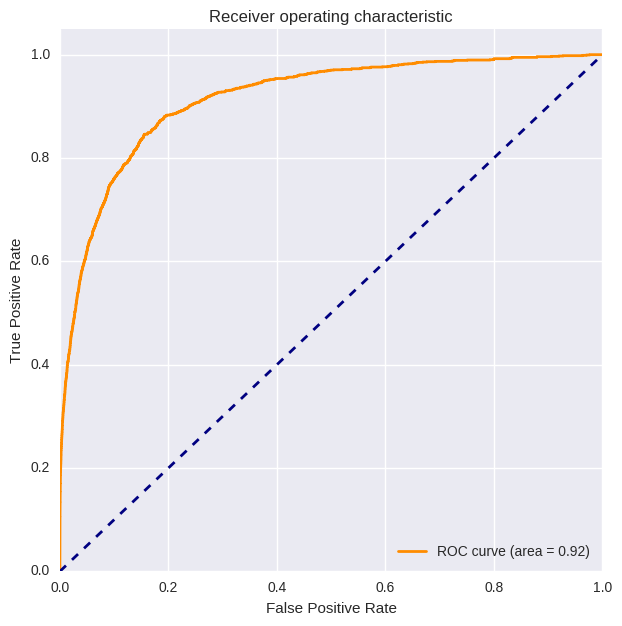

In [19]:
from sklearn.metrics import accuracy_score, auc, recall_score, roc_curve, precision_score, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score, confusion_matrix

fpr, tpr, _ = roc_curve(sig, clf.predict_proba(test_xgb)[:,1], drop_intermediate=True)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

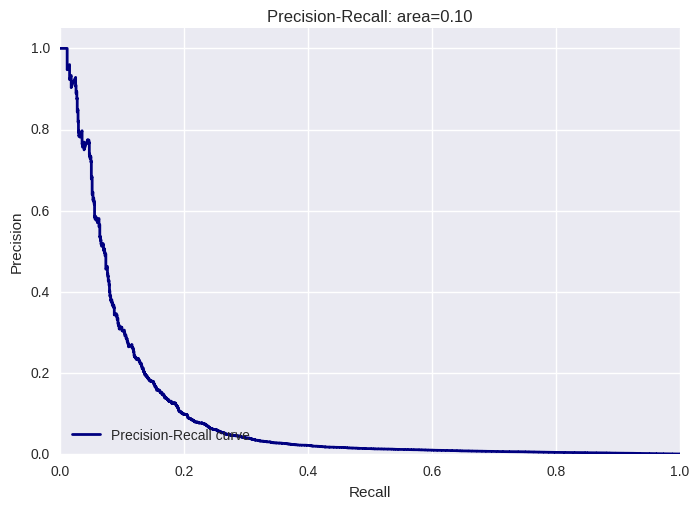

In [20]:
precision, recall, _ = precision_recall_curve(sig, clf.predict_proba(test_xgb)[:,1])
average_precision = average_precision_score(sig, clf.predict_proba(test_xgb)[:,1])
plt.clf()
plt.plot(recall, precision, lw=2, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: area={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

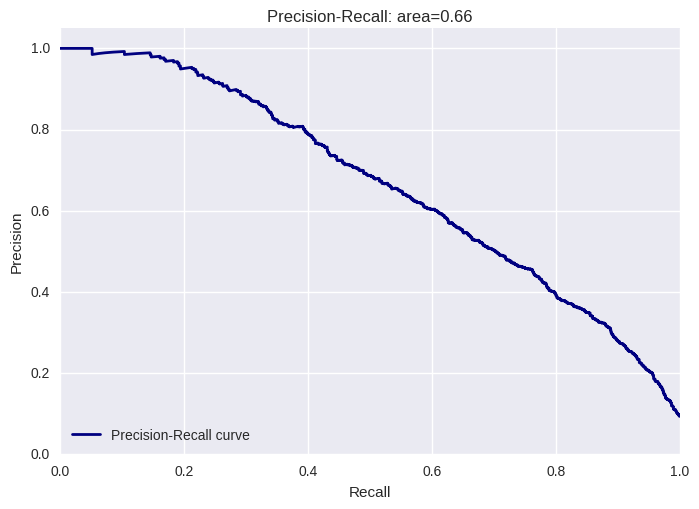

In [21]:
train_np_for_angle = train_np_full[indices]
alpha = angle(train_np_for_angle[:, [1,2,3]] - train_np_for_angle[:, [11, 12, 13]], train_np_for_angle[:, [14, 15, 16]])

precision, recall, _ = precision_recall_curve(sig[alpha < 0.05], clf.predict_proba(test_xgb)[:,1][alpha < 0.05])
average_precision = average_precision_score(sig[alpha < 0.05],clf.predict_proba(test_xgb)[:,1][alpha < 0.05])
plt.clf()
plt.plot(recall, precision, lw=2, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: area={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

In [22]:
l = np.unique(train_np[:,3])

In [23]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def plot_density(data): #2d-data
    m1, m2 = data[0], data[1]
    xmin, xmax = min(m1), max(m1)
    ymin, ymax = min(m2), max(m2)

    x, y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([x.ravel(), y.ravel()])
    values = np.vstack([m1, m2])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, x.shape)

    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.imshow(np.rot90(f), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
    cset = plt.contour(x,y,f)
    plt.clabel(cset, inline=1, fontsize=10)
    plt.colorbar()
    plt.show()

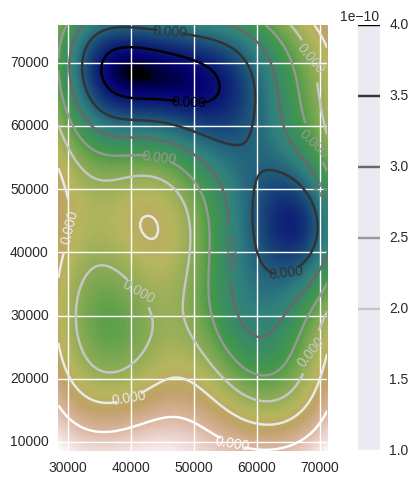

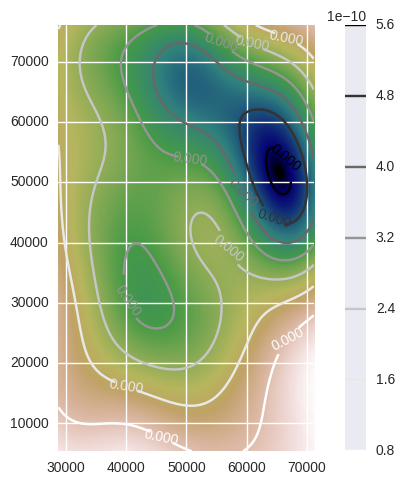

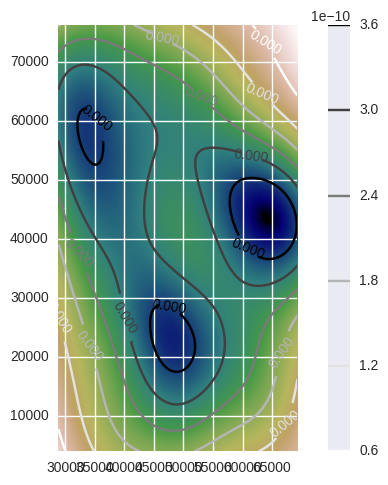

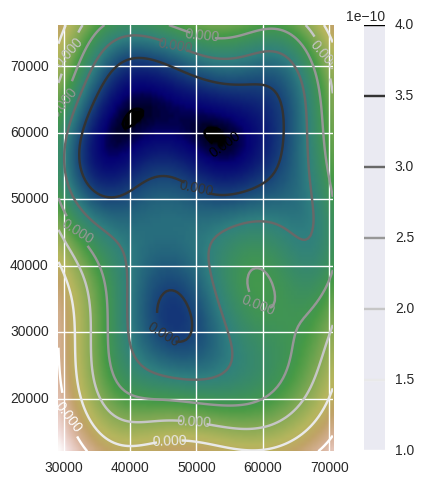

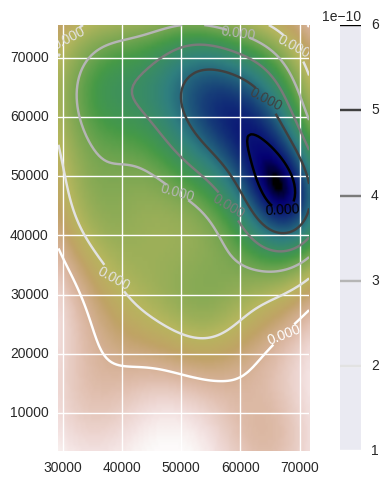

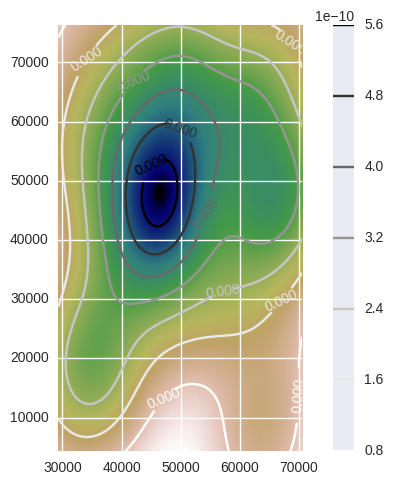

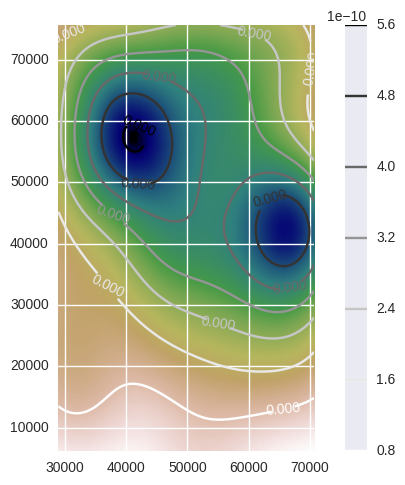

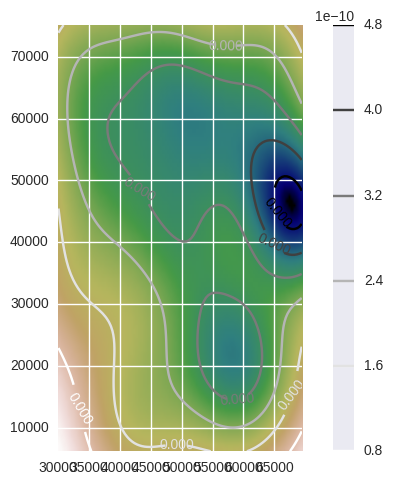

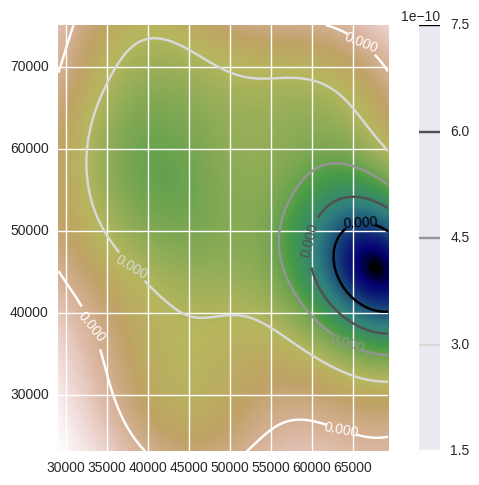

In [24]:
threshold = 0.9
shower = 1
train_np = train_np_full[indices[clf.predict_proba(test_xgb)[:,1] >= threshold]]
shower_id_selected = shower_id[clf.predict_proba(test_xgb)[:,1] >= threshold]
train_np = train_np[shower_id_selected == shower]
train_np[:,0] = np.arange(len(train_np))

for i in range(len(l)):
    plot_density((train_np[:,1][train_np[:,3] == l[i]], train_np[:,2][train_np[:,3] == l[i]]))

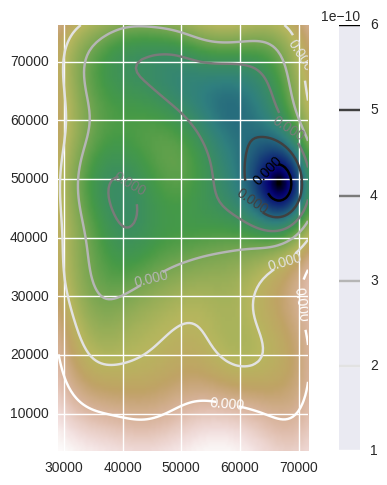

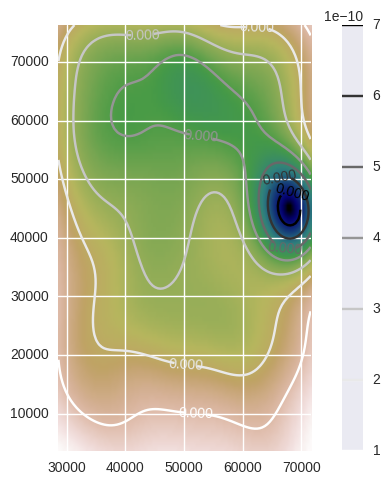

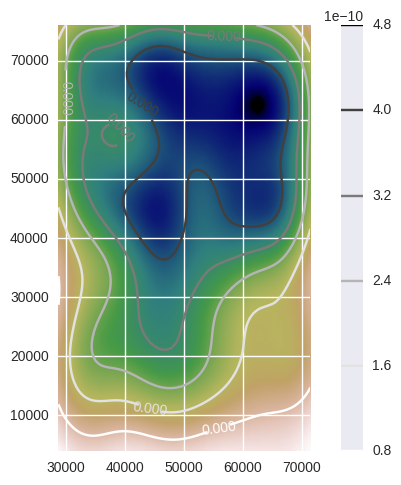

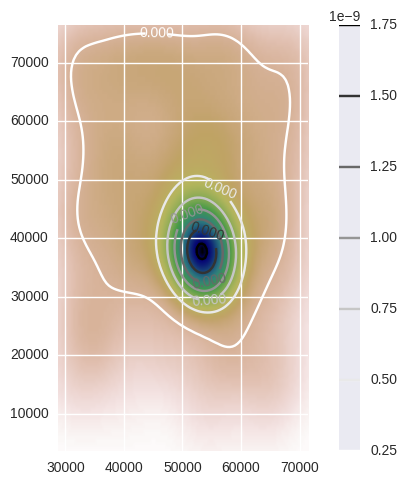

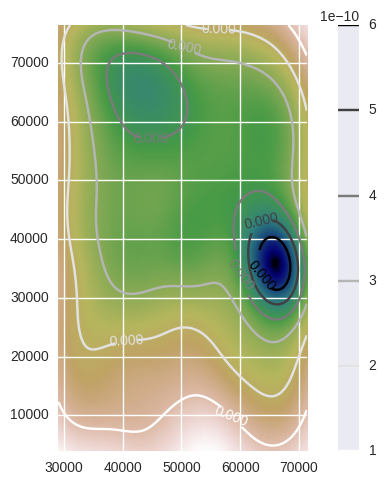

In [25]:
for shower in np.unique(shower_id_selected):
    threshold = 0.9
    train_np = train_np_full[indices[clf.predict_proba(test_xgb)[:,1] >= threshold]]
    shower_id_selected = shower_id[clf.predict_proba(test_xgb)[:,1] >= threshold]
    train_np = train_np[shower_id_selected == shower]
    train_np[:,0] = np.arange(len(train_np))
    plot_density((train_np[:,1], train_np[:,2]))

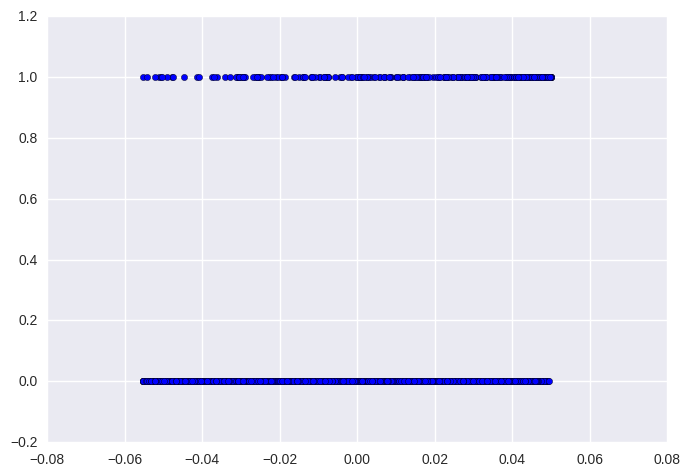

In [26]:
#как выглядит логарифм вероятности в зависимости от истинной метки
#на глаз выбираем константу. В данном случае -- 0.3
log_pred = np.log(clf.predict_proba(test_xgb)[clf.predict_proba(test_xgb)[:,1] > threshold][:,1]) + 0.05
train_np = train_np_full[indices[clf.predict_proba(test_xgb)[:,1] >= threshold]]

plt.scatter(log_pred, train_np[:,10])

In [27]:
threshold = 0.9
shower = 4
train_np = train_np_full[indices[clf.predict_proba(test_xgb)[:,1] >= threshold]]
shower_id_selected = shower_id[clf.predict_proba(test_xgb)[:,1] >= threshold]
train_np = train_np[shower_id_selected == shower]
train_np[:,0] = np.arange(len(train_np))

def plot_3D_shower(train_np):
    x_min = train_np[:,3].min()
    x_max = train_np[:,3].max()
    y_min = train_np[:,1].min()
    y_max = train_np[:,1].max()
    z_min = train_np[:,2].min()
    z_max = train_np[:,2].max()
    d0 = train_np[:,[3,1,2]][train_np[:, 10] == 0]
    d1 = train_np[:,[8,6,7]][train_np[:, 10] == 0]
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(list(zip(d0, d1)), colors=C, alpha=0.5, lw=2)
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-84, elev=5)
    d0 = train_np[:,[3,1,2]][train_np[:, 10] == 1]
    d1 = train_np[:,[8,6,7]][train_np[:, 10] == 1]
    C = plt.cm.Reds(0.5)
    lc_mc = Line3DCollection(list(zip(d0, d1)), colors=C, alpha=0.5, lw=2)

    ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    plt.show()

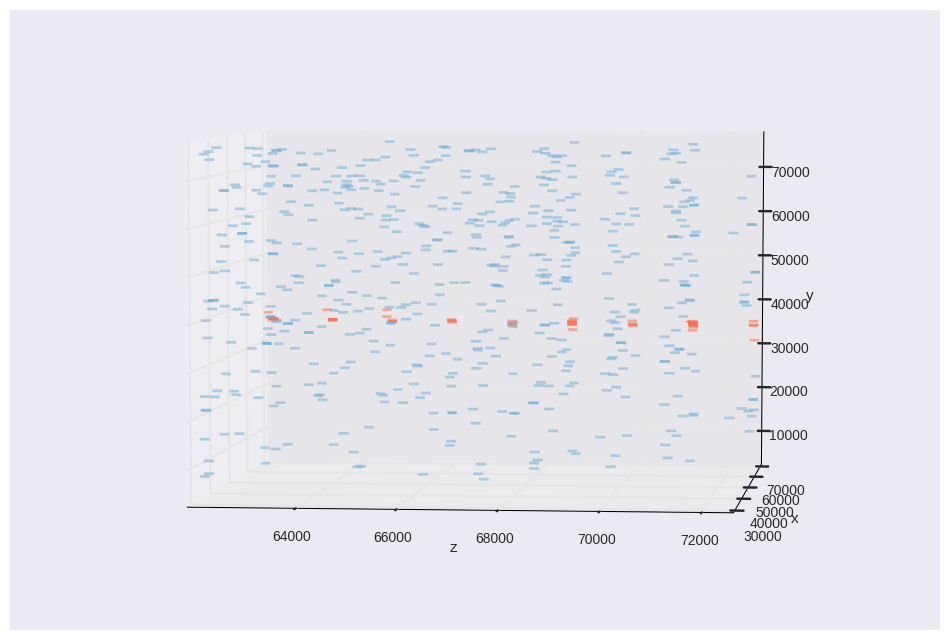

In [28]:
plot_3D_shower(train_np)

In [29]:
train_np_for_angle = train_np_full[indices]
alpha = angle(train_np_for_angle[:, [1,2,3]] - train_np_for_angle[:, [11, 12, 13]], train_np_for_angle[:, [14, 15, 16]])
all_indices_for_pr_auc_cone = np.zeros((0))

for shower in np.unique(shower_id_selected):
    all_indices = np.arange(len(indices))
    threshold = 0.8
    log_pred = np.log(clf.predict_proba(test_xgb)[clf.predict_proba(test_xgb)[:,1] > threshold][:,1]) + 0.05
    train_np = train_np_full[indices[clf.predict_proba(test_xgb)[:,1] >= threshold]]
    shower_id_selected = shower_id[clf.predict_proba(test_xgb)[:,1] >= threshold]
    all_indices_threshold = all_indices[clf.predict_proba(test_xgb)[:,1] >= threshold]
    all_indices_threshold = all_indices_threshold[shower_id_selected == shower]
    train_np = train_np[shower_id_selected == shower]
    log_pred = log_pred[shower_id_selected == shower]
    train_np[:,0] = np.arange(len(train_np))
    import maxflow
    g = maxflow.GraphFloat()
    g.add_nodes(len(train_np))
    g.get_node_count()
    cross_metric = list()
    sig_sig_metric = list()
    n_n_metric = list()
    x_coord = list()
    y_coord = list()
    z_coord = list()
    i = 0
    for potential in log_pred:
        g.add_tedge(i, -potential, 0)
        i += 1

    import tqdm
    from IPython.display import clear_output
    slope = 0.5
    num = 0
    N = 0

    for bt_z in BT_Z_unique:
        curr_train = train_np[(train_np[:,3] < bt_z + 1293.) & 
                             (train_np[:,3] >= bt_z),:] #выбранный слой
        selection = (train_np[:,3] <= bt_z + 3*1293.) & (train_np[:,3] > bt_z) #следующие за ним два слоя
        curr_train_2 = train_np[selection,:]
        for row in (curr_train):
            diff = curr_train_2[:,3] - row[3]
            tmp = curr_train_2[
                ( (curr_train_2[:,1] - row[1]) <= (diff * (row[4] + slope) ) ) &
                ( (curr_train_2[:,1] - row[1]) >= (diff * (row[4] - slope) ) ) &
                ( (curr_train_2[:,2] - row[2]) <= (diff * (row[5] + slope) ) ) &
                ( (curr_train_2[:,2] - row[2]) >= (diff * (row[5] - slope) ) ) ,:] #отбираем те, что в конусе
            num += len(tmp)
            N += 1
            for row_target in tmp:
                if int(row_target[0]) == int(row[0]):
                    continue
                #sig_sig_metric.append(row_target[1] - row[1])

                #the main magic
                #fl = (abs(row_target[4] - row[4]) + abs(row_target[5] - row[5]))# / row_target[9] / row[9]
                #fl = metric_angle(row_target[1:], row[1:])[0]
                #fl = metric_res(row_target[1:], row[1:])
                fl = 0.1 - np.abs(log_pred[row[0]] - log_pred[row_target[0]])
                if fl == 0.: continue
                fl = 1 / (fl + 0.001)
                if (row_target[10] + row[10]) == 0.:
                    n_n_metric.append(fl)
                elif (row_target[10] + row[10]) == 1.:
                    cross_metric.append(fl)
                elif (row_target[10] + row[10]) == 2.:
                    sig_sig_metric.append(fl)
                g.add_edge(int(row[0]), int(row_target[0]), fl, fl)
    g.maxflow()
    predictions = list()
    for i in range(len(train_np)):
        predictions.append(g.get_segment(i))
    predictions = np.array(predictions)
    print (sum(train_np[:,10] * predictions), sum(predictions == 1) - sum(train_np[:,10] * predictions))
    average_precision = average_precision_score(train_np[:,10], predictions)
    all_indices_threshold = all_indices_threshold[predictions == 1]
    all_indices_for_pr_auc_cone = np.concatenate((all_indices_for_pr_auc_cone, all_indices_threshold))
    print (average_precision)
    #plot_3D_shower(train_np[predictions==1,:])
    '''
    precision, recall, _ = precision_recall_curve(train_np[:,10], predictions)
    average_precision = average_precision_score(train_np[:,10], predictions)
    plt.clf()
    plt.plot(recall, precision, lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: area={0:0.2f}'.format(average_precision))
    plt.legend(loc="lower left")
    plt.show()
    '''

/home/acapello/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


14.0 394.0
0.17232061601
68.0 360.0
0.553035100932
16.0 321.0
0.359808183849
143.0 346.0
0.535571699517
65.0 406.0
0.561761710972


In [41]:
selection = np.zeros((len(alpha)))
selection[all_indices_for_pr_auc_cone.astype(int)] = 1
selection = selection.astype(bool)

In [44]:
max(all_indices_for_pr_auc_cone)

1977890.0

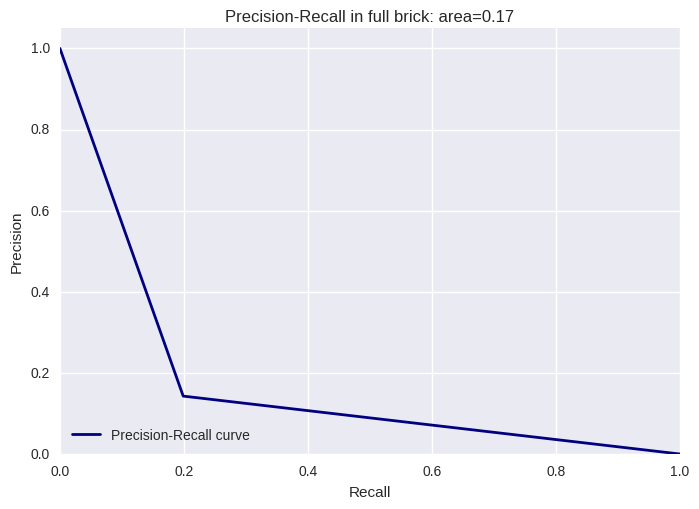

In [47]:
precision, recall, _ = precision_recall_curve(sig, selection)
average_precision = average_precision_score(sig,selection)

plt.clf()
plt.plot(recall, precision, lw=2, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall in full brick: area={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

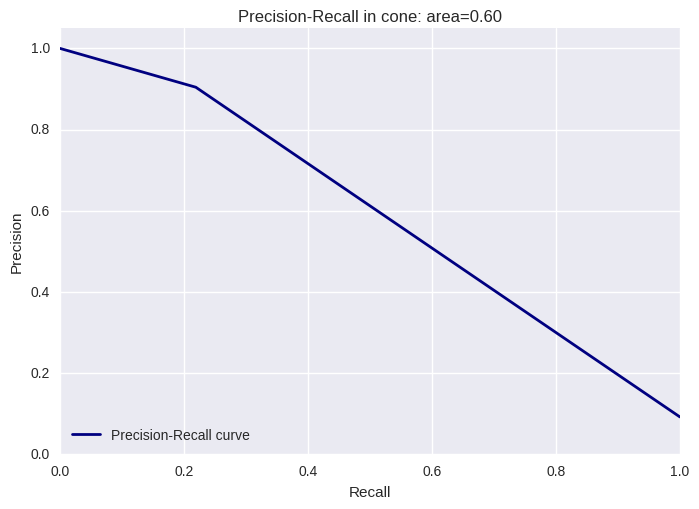

In [48]:
precision, recall, _ = precision_recall_curve(sig[alpha < 0.05], selection[(alpha < 0.05)])
average_precision = average_precision_score(sig[alpha < 0.05],selection[(alpha < 0.05)])

plt.clf()
plt.plot(recall, precision, lw=2, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall in cone: area={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

In [40]:
average_precision

0.59769629747415576

In [33]:
print (len(cross_metric))
print (len(sig_sig_metric))
print (len(n_n_metric)) 

191
533
1465


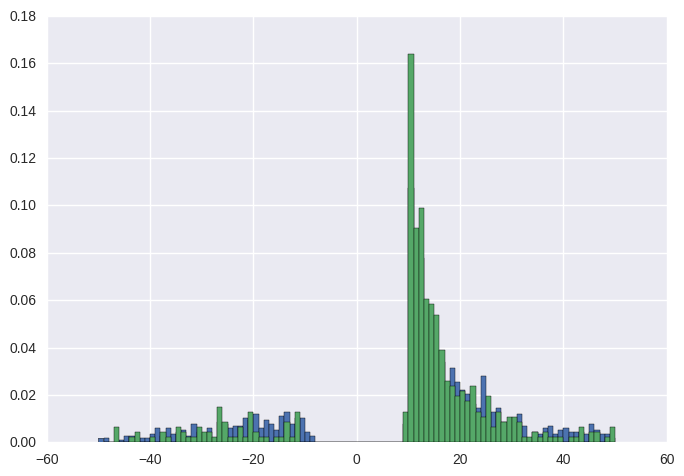

In [34]:
plt.hist(n_n_metric, bins=100, normed=True, range=(-50,50));
plt.hist(sig_sig_metric, bins=100, normed=True, range=(-50,50));

### NearPy заготовка

В данной задаче locality sensitive hashing не особо применим, но может пригодиться в будущем.